In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"  # specify which GPU(s) to be used
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
fold = 1
mode = "curriculum_easy_60idx"
saved_feature = np.load(f"image_features_{mode}_{fold}.npy")

In [3]:
image_feature = saved_feature[:, 2:]
image_feature.shape

(9978, 1280)

In [4]:
n_components_list = range(100, 1000, 100)
result = []
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(image_feature)
    result.append(np.sum(pca.explained_variance_ratio_))
    print(f'Cumulative explained variation for {n_components} principal components: {np.sum(pca.explained_variance_ratio_)}.')

Cumulative explained variation for 100 principal components: 0.9671763489203857.
Cumulative explained variation for 200 principal components: 0.9824296340250898.
Cumulative explained variation for 300 principal components: 0.9892018326676499.
Cumulative explained variation for 400 principal components: 0.9929166586260458.
Cumulative explained variation for 500 principal components: 0.9952251283013783.
Cumulative explained variation for 600 principal components: 0.9967509835058483.
Cumulative explained variation for 700 principal components: 0.9978034720435214.
Cumulative explained variation for 800 principal components: 0.9985460455910661.
Cumulative explained variation for 900 principal components: 0.9990740294180135.


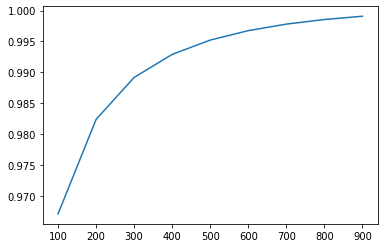

In [5]:
plt.plot(n_components_list, result)

In [6]:
pca_result.shape

(9978, 900)

In [7]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9978 samples in 0.619s...
[t-SNE] Computed neighbors for 9978 samples in 82.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9978
[t-SNE] Computed conditional probabilities for sample 2000 / 9978
[t-SNE] Computed conditional probabilities for sample 3000 / 9978
[t-SNE] Computed conditional probabilities for sample 4000 / 9978
[t-SNE] Computed conditional probabilities for sample 5000 / 9978
[t-SNE] Computed conditional probabilities for sample 6000 / 9978
[t-SNE] Computed conditional probabilities for sample 7000 / 9978
[t-SNE] Computed conditional probabilities for sample 8000 / 9978
[t-SNE] Computed conditional probabilities for sample 9000 / 9978
[t-SNE] Computed conditional probabilities for sample 9978 / 9978
[t-SNE] Mean sigma: 1.219425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.401688
[t-SNE] KL divergence after 300 iterations: 2.781646
t-SNE done! Time elapsed: 273.3683142

In [8]:
df = pd.read_csv("../Data_CSV/Train_Data.csv")
isup_grade = df["isup_grade"].to_numpy().reshape(-1,1)
isup_grade.shape
tsne_results_ = np.concatenate([tsne_results, isup_grade], axis = 1)

In [9]:
np.save(f"tsne_results_3cmp_{mode}_{fold}.npy", tsne_results)

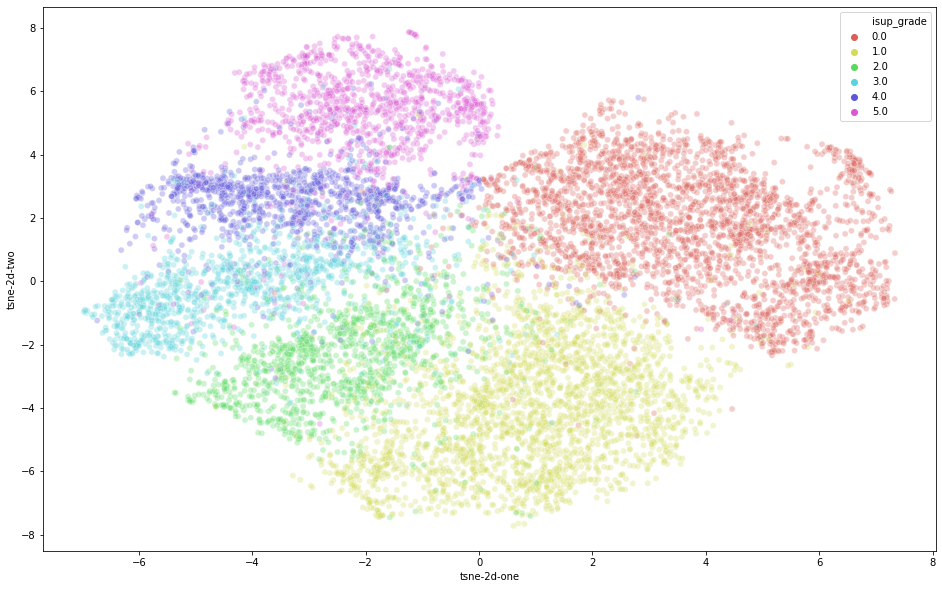

In [10]:
tsne_results_pd = pd.DataFrame(tsne_results_, columns=['tsne-2d-one', 'tsne-2d-two', 'tsne-2d-three', "isup_grade"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="isup_grade",
    palette=sns.color_palette("hls", 6),
    data=tsne_results_pd,
    legend="full",
    alpha=0.3
)

### K-means

In [11]:
n_clusters = 12
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(tsne_results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

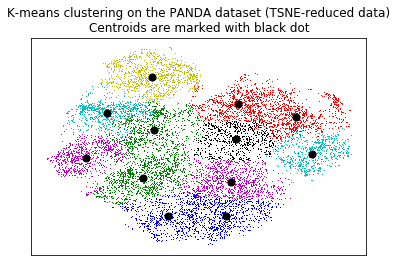

In [12]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
# y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
# z_min, z_max = tsne_results[:, 2].min() - 1, tsne_results[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h),np.arange(z_min, z_max, h))

# Obtain labels for each point in mesh. Use last trained model.
# Z = k_means.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z_org = k_means.predict(tsne_results)

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(n_clusters):
    plt.plot(tsne_results[Z_org == i,0], tsne_results[Z_org == i,1], color[i%len(color)] + ',', markersize=2)

# Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=50, linewidths=1,
            color='k', zorder=10)
plt.title('K-means clustering on the PANDA dataset (TSNE-reduced data)\n'
          'Centroids are marked with black dot')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [13]:
df["k_means_grp"] = Z_org
df["image_idx"] = range(len(df))
df.head()
df.to_csv(f"./Train_Data_{mode}_{fold}.csv", index = False)

In [14]:
df.head()

,image_id,data_provider,isup_grade,gleason_score,tile_number,split,tile_pixel,tile_blueratio,image_idx,k_means_grp
0,9716b5d2e13a28be3dc836134153720c,radboud,4,4+4,7,1.0,"121,109,111,86,81,79,77,","48,40,46,33,32,33,28,",0,10
1,0954f0bb123cf3be8b00c9c989dcf3d6,karolinska,0,0+0,43,1.0,"152,141,135,134,127,128,128,123,126,122,117,11...","47,41,43,40,45,44,39,43,45,43,48,42,40,33,41,3...",1,2
2,d861180850ca54282b38c782734a7dc7,karolinska,0,0+0,39,0.0,"89,82,72,67,70,69,69,60,61,69,68,69,58,57,60,6...","32,30,29,29,25,27,26,26,26,25,25,25,26,25,26,2...",2,6
3,459154b1334d073cfef8af95362a7051,karolinska,0,0+0,34,1.0,"112,103,102,99,92,89,97,90,94,88,83,83,82,79,7...","42,34,40,33,37,31,38,31,33,33,29,30,33,31,30,2...",3,6
4,27489a7f1972687cccb1258116ff7f10,karolinska,0,0+0,24,0.0,"105,101,101,92,87,85,84,89,86,83,81,77,73,80,7...","34,35,37,35,32,31,32,29,31,29,31,28,28,29,27,2...",4,3


Text(0.5, 1.0, 'K-means clustering on the PANDA dataset (TSNE-reduced data)')

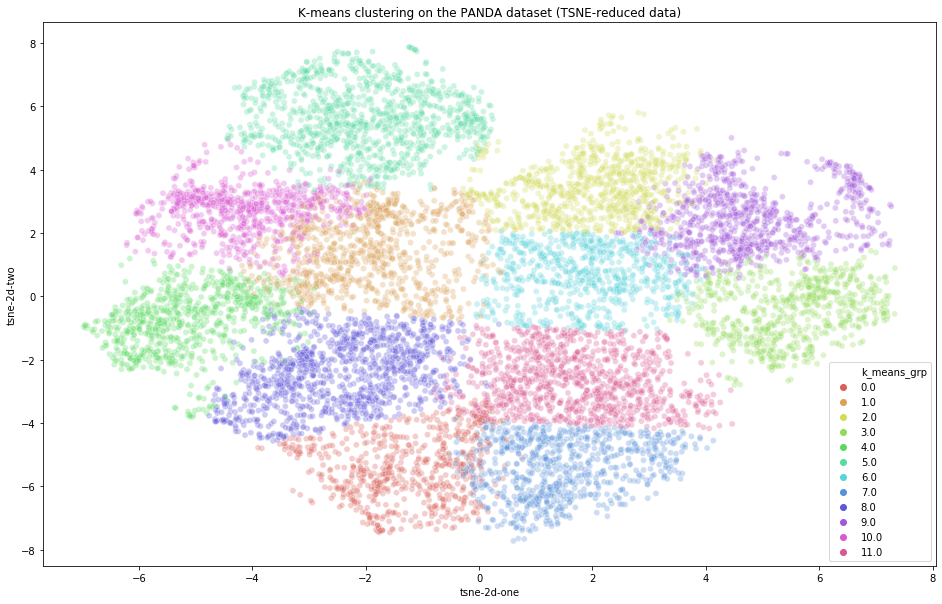

In [15]:
k_means_result_pd = pd.DataFrame(np.concatenate([tsne_results, np.asarray(Z_org).reshape(-1,1)],1),
                                 columns=['tsne-2d-one', 'tsne-2d-two', 'tsne-2d-three', "k_means_grp"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="k_means_grp",
    palette=sns.color_palette("hls", 12),
    data=k_means_result_pd,
    legend="full",
    alpha=0.3
)
plt.title('K-means clustering on the PANDA dataset (TSNE-reduced data)')

In [16]:
tsne_results.shape, np.asarray(Z_org).reshape(-1,1).shape

((9978, 3), (9978, 1))